# Описание проекта

**Проект:** "Прогнозирование температуры звезды"<br>
<br>
**Заказчик** — Обсерватория «Небо на ладони»<br>
**Цель проекта** - Разработать нейросеть, определяющую температуру на поверхности звёзд по данным, предоставленным заказчиком.
<br>
**Ограничения -** RMSE не более 4500
<br>

**Предоставленные данные содержат информацию о 240 звездах.**
<br>

**Структура предоставленных данных :**
<br>
* Первое поле без названия
* `Temperature (K)` — абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.
* `Luminosity(L/Lo)` — относительная светимость L/Lo — светимость звезды относительно Солнца.
* `Radius(R/Ro)` — относительный радиус R/Ro — радиус звезды относительно радиуса Солнца
* `Absolute magnitude(Mv)` — абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды
* `Star type` — тип звезды
* `Star color` — звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа
<br>

**Этапы реализации проекта:**<br>
* Построение простой модели нейронной сети — baseline
* Улучшение сети - ругуляризация
* Выводы по проекту

**План проекта:**
* Загрузка данных
* Предобработка и анализ данных
* Подготовка данных для формирования сети
* Построение простой модели нейронной сети — baseline
* Построение модели нейронной сети с учетом регуляризации
* Выводы по проекту

# Импорт библиотек и глобальные установки

In [1]:
# Импорт

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt

from math import ceil

import phik
from phik.report import plot_correlation_matrix

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn



# Установки

np.random.seed(42)
torch.manual_seed(42)
torch.use_deterministic_algorithms(True)

warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None) # Отображать все поля DF
pd.set_option('display.max_colwidth', None)  # Отображать все содержание полей DF

RANDOM_STATE = 2025

class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

color_end = color.END
red_start = color.RED
blue_start = color.BLUE
purple_start = color.PURPLE

# Функции

## `categorical_property_visualization` - визуализация категориальных признаков

In [26]:
def categorical_property_visualization(
    data_,
    indexes_=[],
    titles_=[],
    values_='',
    aggfunc_='count',
    nrows_=2,
    ncols_=3,
    figsize_=(20, 7),
    title_ = '',
    y_title_ = 1
):
    
    columns = data_.columns
    record_count = data_.shape[0]
    
    row_ind = 0
    col_ind = 0
    subplot_ind = 0
    
    if nrows_ * ncols_ < len(indexes_):
        print('Несоответствие - nrows_ * ncols_ < len(indexes_)')
        return

    fig, axes = plt.subplots(nrows = nrows_, ncols = ncols_, figsize = figsize_)
    fig.suptitle(title_, fontsize=20, y = y_title_)

    for x in axes.ravel():
        x.axis("off")    
        #print(row_ind, col_ind)
        #print(len(axes.shape))

    for ind in indexes_:
        if len(axes.shape) == 1:
            current_ax = axes[subplot_ind]
        else:
            current_ax = axes[row_ind, col_ind]
        
        for_plot_df = data_.pivot_table(
                index=ind,
                values=values_,
                aggfunc=aggfunc_
            )
        for_plot_df.columns = ['count']
        for_plot_df.plot(
                kind='pie',
                ax = current_ax,
                #y='id',
                y='count',
                autopct='%1.0f%%'
            )
        current_ax.set_title(titles_[subplot_ind])
        current_ax.get_legend().remove()
            
        subplot_ind += 1
        col_ind += 1
        if col_ind == ncols_: #3
            col_ind = 0
            row_ind += 1

## `column_analiser` - визуализация числовых признаков

In [3]:
def column_analiser(
    df_,
    column_,
    x_label='',
    y_label='',
    print_unique = False,
    bins_= 70,
    figsize_ = (15, 10),
    height_ratios_ = [1, 3],
    hue_lst_ = [],
    kde_plot_log_flag_ = False,
    kde_plot_figsize_ = (15, 10),
    kde_plot_title = '',
    kde_plot_x_label = '',
    kde_plot_y_label = ''
):

    record_count = df_.shape[0]
    
    print('---------------------------------------------------------------------------------------------------------')
    print(blue_start, f'Поле : {column_} - {x_label}', color_end)
    isna_count = df_[column_].isna().sum()
    print(blue_start, '    Количество пропусков - ', color_end, isna_count)
    print(blue_start, '    Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), '%')
    print('')
    
    print(df_[column_].describe())
    if print_unique:
        print('Список значений')
        print(df_[column_].unique())
        
    fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = figsize_, gridspec_kw={'height_ratios': height_ratios_})
        
    if kde_plot_log_flag_:
        axes[0] = np.log1p(df_[column_]).plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            np.log1p(df_[column_]),
            bins=bins_
        )
    else:
        axes[0] = df_[column_].plot(
            kind = 'box',
            ax = axes[0],
            vert=False)
        axes[1] = plt.hist(
            df_[column_],
            bins=bins_,
        )

    axes[0].set_ylabel(y_label)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title('Распределение')    
    plt.show()    
    
    if len(hue_lst_) > 0:
        for hue_ in hue_lst_:
            print('kde_plot_log_flag_ = ', kde_plot_log_flag_)
            if kde_plot_log_flag_:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = np.log1p(df_[column_]),
                            hue = hue_,
                            fill = True)
            else:
                fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = kde_plot_figsize_)
                sns.kdeplot(data = df_,
                            x = df_[column_],
                            hue = hue_,
                            fill = True)
                
            plt.title(kde_plot_title)
            plt.xlabel(kde_plot_x_label)
            plt.ylabel(kde_plot_y_label)
            plt.show()

## `check_categorical_fields` - вывод уникальных значений полей

In [4]:
def check_categorical_fields(df_, fields_lst, print_unique_val=False):
    record_count = df_.shape[0]
    for field in fields_lst:
        print('---------------------------------------------------------------------------------------------------------')
        print(blue_start, 'Поле - ', color_end, field)
        print(blue_start, 'Количество уникальных значений -  ', color_end, len(df_[field].unique()))

        isna_count = df_[field].isna().sum()
        print(blue_start, 'Количество пропусков - ', color_end, isna_count)
        if isna_count > 0:
            print(blue_start, 'Доля пропусков - ', color_end, round((isna_count / record_count) * 100, 2), bold_start, '%')
        print('')
        if print_unique_val:
            with pd.option_context("display.max_rows", None):
                unique_count_df = pd.DataFrame(df_[field].value_counts().sort_index(ascending = True)).reset_index()
                unique_count_df.columns = ['Значение', 'Количество']
                display(unique_count_df)

## `df_inf` - информация о дата фрейме

In [5]:
def df_inf(df, head_row=5, drop_duplicates_flag=False):
    print(purple_start, '-------------------------------------------------------------------------------------------------------------------------------------', color_end)
    try:
        df_name = df.name
        print(blue_start,'Имя:', df_name, color_end)
    except:
        df_name = 'Не определено'
        display(blue_start,'Имя: Не определено', color_end)
    print('')
    
    df_shape_ = df.shape
    
    print(blue_start, df_name, '(первые', head_row, 'строк)', color_end)
    display(df.head(head_row))
    print('')
    
    print(blue_start,'Информация: ', color_end)
    df.info()
    print('')

    try:
        print(blue_start,'Описание числовых полей: ', color_end)
        display(df.describe(exclude=['O']))
    except ValueError:
        print(blue_start,'Числовых полей нет!', color_end)
        
    print('')
    
    try:
        print(blue_start,'Описание не числовых полей: ', color_end)
        display(df.describe(include=['O']))
    except ValueError:
        print(blue_start,'Не числовых полей нет!', color_end)
        
    print('')

    print(blue_start,'Пропуски: ', color_end)
    display(df.isna().sum().T)
    print('')
    
    df_duplicates = []
    df_duplicates = df[df.duplicated()]

    #isna_record_count  = df[df.isnull().any(axis=1)].drop_duplicates().shape[0]
    record_count = df_shape_[0]
    isna_record_count  = df[df.isnull().any(axis=1)].shape[0]
    
    print(blue_start, 'Доля записей, содержащих пропуски:',color_end, round((isna_record_count/record_count)*100, 2),'%')
    
    if len(df_duplicates) > 0:
        print(' ')
        print(blue_start,'Количество дубликатов:',len(df_duplicates), color_end)
        print(blue_start,'Дубликаты (первые', head_row, 'строк)', color_end)
        display(df_duplicates.head(head_row))
        if drop_duplicates_flag:
            print(blue_start,'Дубликаты удалены!', color_end)
            df.drop_duplicates(keep = 'first', inplace = True)
            df_duplicates = df[df.duplicated()]
            print(blue_start,'Количество дубликатов после удаления:',len(df_duplicates), color_end)
    else:
        print(blue_start,'Дубликаты не обнаружены!', color_end)
    print(' ')
    return df_duplicates, df_shape_

## `load_date` - загрузка файлов

In [6]:
# Функция загрузки file_name_ с возможностью парсинга даты (парсить/не парсить) 
# и отображением первых file_name_ строк
# последовательность попыток загрузки по локациям:
#    - текущая (локальная) директория 
#    - директория тренажера
#    - https://code.s3.yandex.net/datasets/

def load_date(
    file_name_,
    parse_dates_,
    head_rows_ = 1):
    
    read_csv_res = red_start + 'ОШИБКА - ' + file_name_ + '- не загружен' + color_end
    err = False
    try:
        df_ = pd.read_csv(
            file_name_,
            parse_dates = parse_dates_
        )
        read_csv_res = blue_start + file_name_ + ' загружен из локальной директории' + color_end
    except:
        try:
            file_path = '/datasets/'
            df_ = pd.read_csv(
                file_path + file_name_,
                parse_dates = parse_dates_
            )
            read_csv_res = blue_start + file_name_ + ' загружен в тренажере' + color_end
        except:
            try:
                file_path = 'https://'
                df_ = pd.read_csv(
                    file_path + file_name_,
                    parse_dates = parse_dates_
                )
                read_csv_res = blue_start + file_name_ + ' загружен из - ' + file_path + color_end
            except:
                read_csv_res = red_start + 'ОШИБКА - '  + file_name_ + ' - не загружен' + color_end
                err = True
    print(read_csv_res)
    if err:
        return 'ОШИБКА ЧТЕНИЯ'
    else:
        df_.name = file_name_
        display(df_.head(head_rows_))
        return df_

## `cross_vall_score` - определение RMSE модели по параметрам

In [7]:
# Функция для определения лучших параметров сети по значению RMSE

def cross_vall_score(
    model,
    X_train,
    y_train,
    optimizer,
    epochs_count = 0,
    batch_size = 0,
    optimize_iteration_count = 0,
    loss = nn.MSELoss()
                    ):

    # количество батчей
    batch_count = ceil(len(X_train)/batch_size)

    # размер валидационной выборки 
    validation_size = len(X_train)//optimize_iteration_count
    
    scores_ = []
    
    for iteration in range(optimize_iteration_count):
        
        #обнуляем веса уровней сети
        for layer in model.children():
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
            
        #формирование валидационной и тренировочной выборок
        #валидационная выборка
        validation_data = X_train[iteration * validation_size: (iteration + 1) * validation_size]
        val_targets = y_train[iteration * validation_size: (iteration + 1) * validation_size]
        
        #тренировочная выборка
        train_data_part = np.concatenate(
            [
                X_train[: iteration * validation_size],
                X_train[ (iteration + 1) * validation_size:]
            ], axis = 0
                                           )
        train_targets_part = np.concatenate(
            [
                y_train[: iteration * validation_size],
                y_train[ (iteration + 1) * validation_size:]
            ], axis = 0
                                              )
        
        #формироыание тензоров
        validation_data = torch.FloatTensor(validation_data)
        val_targets = torch.FloatTensor(val_targets)
        train_data_part = torch.FloatTensor(train_data_part)
        train_targets_part = torch.FloatTensor(train_targets_part)

        # цикл по эпохам
        for epoch in range(epochs_count):
            # формирование случайного набора индексов
            order = np.random.permutation(len(train_data_part))

            #цикл по батчам внутри эпохи
            for batch_idx in range(batch_count):
                # обнуление градиентов
                optimizer.zero_grad()

                #значение первого индекса батча
                start_index = batch_idx * batch_size

                #Формирование входящих признаков и таргета текущего батча
                batch_indexes = order[start_index : start_index + batch_size]
                
                X_batch = train_data_part[batch_indexes]
                y_batch = train_targets_part[batch_indexes]

                #формирование прогноза по батчу
                predicts = model.forward(X_batch).flatten()

                #вычисление потерь
                loss_value = loss(predicts, y_batch.flatten())

                #вычисление значения градиента функции потерь
                loss_value.backward()

                #шаг работы оптимизатора (обновление весов сети)
                optimizer.step()

            # формирование прогноза и потерь по валидационной выборке по последней эпохе
            if epoch == epochs_count - 1:
#                print('epoch = ', epoch)

                # перевод модели в режим предсказания.В этом режиме не будут 
                # вычисляться и накапливаться градиенты.
                model.eval()

                #формирование прогноза по валидационной выбоорке
                val_predict = model.forward(validation_data)
                
                RMSE_ = round(float(torch.sqrt(loss(val_targets, val_predict))), 4)
                scores_.append(RMSE_)
                print(
                    blue_start, '    Итерация ',color_end,iteration + 1,
                    blue_start, 'RMSE = ',color_end,RMSE_
                     )
    mean_rmse = round((sum(scores_) / len(scores_)), 4)
    print(
        blue_start,
        'Средняя RMSE =',
        color_end,
        mean_rmse,  '\n'
         )
    return mean_rmse #scores_

## `cross_val_run` - запуск процесса кросс валидации по модели.

In [8]:
def cross_val_run(
    net,
    X_train_torch,
    y_train_torch,
    optimazer_lst, #OPTIMIZER_LST
    bach_size = 0, #BATCH_SIZE
    epochs_count = 0, #EPOCHS_COUNT
    optimize_iteration_count = 0, #OPTIMAZE_ITTERATION_COUNT
    loss = 0 #LOSS
):
    optimizer_index = 0
    scores_ = []

    # Цикл по оптимизаторам
    for optimizer in optimazer_lst:
        print(
            blue_start,
            '-------------------------------------------------------------------',
            color_end
             )
        print(blue_start, 'Оптимизатор - ', color_end)
        display(optimizer)

        # Цикл по размерам батча
        for current_bach_size in bach_size:
            print(blue_start, 'batch_size = ', color_end, current_bach_size)

            # Фиксация результатов работы модели по текущему оптимизатору и размеру батча
            scores_.append([
                optimizer_index,
                current_bach_size,
                cross_vall_score(
                    net,
                    X_train_torch,
                    y_train_torch,
                    optimizer,
                    epochs_count = EPOCHS_COUNT,
                    batch_size = current_bach_size, #BATCH_SIZE,
                    optimize_iteration_count = OPTIMAZE_ITTERATION_COUNT,
                    loss = LOSS
                                )]
                         )
        optimizer_index += 1
    return scores_

## `add_columns` - добавляет столбцы в `to_df` из `from_df`, которых нет в `to_df`

In [9]:
def add_columns(from_df, to_df, fill_value = 0, sort_column_flag = False):
#    print(from_df.columns[~from_df.columns.isin(to_df.columns)])
    new_column_lst = from_df.columns[~from_df.columns.isin(to_df.columns)]
    for i in new_column_lst:
        to_df[i] = fill_value
#        print(i)
#    display(to_df.head(2))
    if sort_column_flag:
        to_df = to_df.reindex(sorted(to_df.columns), axis=1)
    return new_column_lst, to_df

## `get_best_optimizer_index` - возвращает индекс лучшего оптимизатора

In [10]:
def get_best_optimizer_index(scores_):
    scores_mean = np.mean(scores_, axis=1).tolist()
    read_csv_res = blue_start + file_name_ + ' загружен из - ' + file_path + color_end
    print(blue_start, scores_mean, color_end)
    best_optimizer_score_index = scores_mean.index(min(scores_mean))
    print(blue_start,'Средняя RMSE =', color_end, min(scores_mean))
    return best_optimizer_score_index

## `fit_model` - обучение модели по параметрам

In [11]:
# Функция обучает сеть батчами с заданным количеством эпох
def fit_model(
    model,
    X_train,
    y_train,
    optimizer,
    epochs_count = 0,
    batch_size = 0,
    loss = nn.MSELoss()
             ):

    # Вычисление количества батчей
    batch_count = ceil(len(X_train) / batch_size)

    # Цикл по эпохам
    for epoch in range(epochs_count):
        #случайная перестановка индексов
        order = np.random.permutation(len(X_train))
        # Цикл по батчам
        for batch_idx in range(batch_count):
            start_index = batch_idx * batch_size 
            optimizer.zero_grad() 

            #индексы для текущего батча
            batch_indexes = order[start_index:start_index + batch_size]

            # выборка входящих параметров, включающая batch_indexes
            X_batch = X_train[batch_indexes]
            # таргет - выборка, включающая batch_indexes
            y_batch = y_train[batch_indexes]

            # получение прогноза
            preds = model.forward(X_batch).flatten() 

            # вычисление потерь
            loss_value = loss(preds, y_batch.flatten())
            
            # вычисление значение градиента функции потерь
            loss_value.backward()
            # выполнение шага работы оптимизатора (обновление весов в сети)
            optimizer.step()
    return  model

## `Model` - определение класса модели для прогнозирования

In [12]:
# Параметры модели:
# n_in_neurons - количество нейронов на входе
# n_hidden_neurons_1  - количество нейронов первого слоя
# n_hidden_neurons_2  - количество нейронов второго слоя
# n_hidden_neurons_3  - количество нейронов третьего слоя
# n_out_neurons       - количество нейронов на выходе
# normalization_flag  - параметр определяет включать (True), или не включать (False) регуляризацию

# третий слой закоментарен, т.к. не результативен

class Model(nn.Module):
    def __init__(
        self,
        n_in_neurons,
        n_hidden_neurons_1,
        n_hidden_neurons_2,
        n_hidden_neurons_3,
        n_out_neurons,
        normalization_flag = False
                ):
        
        super(Model, self).__init__()

        self.normalization_flag = normalization_flag
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        if normalization_flag:
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        if normalization_flag:
            self.dp2 = nn.Dropout(p = 0.2)
##            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)

#        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
#        self.act3 = nn.ReLU()
        
#        if normalization_flag:
#            self.dp3 = nn.Dropout(p = 0.2)
#            self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)

#        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
#        self.act4 = nn.Sigmoid()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        self.act3 = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        if self.normalization_flag:
            x = self.bn1(x)
        x = self.act1(x)
        
        if self.normalization_flag:
            x = self.dp2(x)
        x = self.fc2(x)
##        if self.normalization_flag:
##            x = self.bn2(x)
        x = self.act2(x)
        
#        if self.normalization_flag:
#            x = self.dp3(x)
#        x = self.fc3(x)
#        if self.normalization_flag:
#            x = self.bn3(x)
#        x = self.act3(x)
        

#        x = self.fc4(x)

        x = self.fc3(x)
        
        return x

## `get_optimizer_lst` - возвращает список оптимизаторов для объекта класса `Model`

In [13]:
def get_optimizer_lst(net_):
    optimizer_lst_ = [
        torch.optim.RMSprop(net_.parameters(), lr=1e-3),
        torch.optim.RMSprop(net_.parameters(), lr=1e-2),
        
        torch.optim.Adam(net_.parameters(), lr = 1e-3),
        torch.optim.Adam(net_.parameters(), lr = 1e-2),
    
        torch.optim.Adamax(net_.parameters(), lr = 1e-3),
        torch.optim.Adamax(net_.parameters(), lr = 1e-2)
    ]    
    return optimizer_lst_

## `get_best_model_validation_params` - возвращает параметры модели с минимальным RMSE

In [14]:
def get_best_model_validation_params(
    scores_,
    optimazer_lst,
    metrica_field = 'RMSE',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size'):

    # Поиск best_optimizer_score_index - индекс оптимизатора с минимальным значением metrica_field
    best_optimizer_score_index = scores[optimizer_index_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]
    
    # Поиск best_batch_size - оптимального размера батча для 
    # минимального значением metrica_field
    best_batch_size = scores[batch_size_field].loc[
    scores[metrica_field] == scores[metrica_field].min()
    ].values[0]

    # Минимальное значение метрики
    best_metrica_val = scores[metrica_field].loc[scores[metrica_field] == scores[metrica_field].min()].values[0]
    
    print(blue_start, 'Оптимальные параматры модели:', color_end)
    best_optimazer = optimazer_lst[best_optimizer_score_index]
    print(blue_start, '    Лучший оптимайцзер - ', color_end, optimazer_lst[best_optimizer_score_index].__class__.__name__)
    print(blue_start, '    Индекс оптимизатора - ', color_end, best_optimizer_score_index)
    print(blue_start, '    Размер батча - ', color_end, best_batch_size)
    
    print(' ')
    print(blue_start, 'Значение метрики - ', best_metrica_val, color_end)
    
    return best_optimizer_score_index, best_batch_size, best_metrica_val

## `harvard_color_stars_method` - возвращает цвет в соответствии с температурой планеты по Гарвардскому классификатору

In [15]:
def harvard_color_stars_method(temperature_):
    if temperature_ > 30000:
        return 'blue'
    elif 30000 >= temperature_ > 10000:
        return 'blue_white'
    elif 10000 >= temperature_ > 7400:
        return 'white'
    elif 7400 >= temperature_ > 6000:
        return 'yellow_white'
    elif 6000 >= temperature_ > 5000:
        return 'yellow'
    elif 5000 >= temperature_ > 3800:
        return 'orange'
    else:
        return 'red'

# Загрузка данных

In [16]:
stars_df = load_date(file_name_ = '6_class.csv', parse_dates_ = [], head_rows_ = 3)

6_class.csv загружен из локальной директории


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red
2,2,2600,0.0003,0.1020,18.70,0,Red


## `Выводы`

* Данные загружены

# Предобработка данных

## Переименование полей (Snake case стиль)

In [17]:
original_columns = stars_df.columns
stars_df.columns = [
    'star_index',
    'temperature',
    'luminosity',
    'radius',
    'absolute_magnitude',
    'star_type',
    'star_color'
]
stars_df.set_index('star_index', inplace = True)

## Информация о датафрейме

In [18]:
duplicates_df, stars_df__original_shape = df_inf(df = stars_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: 6_class.csv 

 6_class.csv (первые 3 строк) 


,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
star_index,,,,,,
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red
2,2600,0.0003,0.1020,18.70,0,Red



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB

 Описание числовых полей:  


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396,2.500000
std,9552.425037,179432.244940,517.155763,10.532512,1.711394
min,1939.000000,0.000080,0.008400,-11.920000,0.000000
25%,3344.250000,0.000865,0.102750,-6.232500,1.000000
50%,5776.000000,0.070500,0.762500,8.313000,2.500000
75%,15055.500000,198050.000000,42.750000,13.697500,4.000000
max,40000.000000,849420.000000,1948.500000,20.060000,5.000000



 Описание не числовых полей:  


,star_color
count,240
unique,19
top,Red
freq,112



 Пропуски:  


temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


In [19]:
# Замена типов категориальных полей

stars_df['star_color'] = stars_df['star_color'].astype('category')
stars_df['star_type'] = stars_df['star_type'].astype('category')

In [20]:
# Вывод информации по уникальным значениям категориальных полей
cat_field_lst = ['star_color', 'star_type']
check_categorical_fields(df_ = stars_df, fields_lst = cat_field_lst, print_unique_val = True)

---------------------------------------------------------------------------------------------------------
 Поле -   star_color
 Количество уникальных значений -    19
 Количество пропусков -   0



,Значение,Количество
0,Blue,55
1,Blue,1
2,Blue White,10
3,Blue white,3
4,Blue white,1
5,Blue-White,1
6,Blue-white,26
7,Orange,2
8,Orange-Red,1
9,Pale yellow orange,1


---------------------------------------------------------------------------------------------------------
 Поле -   star_type
 Количество уникальных значений -    6
 Количество пропусков -   0



,Значение,Количество
0,0,40
1,1,40
2,2,40
3,3,40
4,4,40
5,5,40


In [21]:
stars_df['star_color'] = stars_df['temperature'].apply(harvard_color_stars_method)

In [22]:
# Вывод информации по уникальным значениям категориальных полей
# после внесенных изменений

cat_field_lst = ['star_color', 'star_type']
check_categorical_fields(df_ = stars_df, fields_lst = cat_field_lst, print_unique_val = True)

---------------------------------------------------------------------------------------------------------
 Поле -   star_color
 Количество уникальных значений -    7
 Количество пропусков -   0



,Значение,Количество
0,blue,14
1,blue_white,76
2,orange,7
3,red,109
4,white,21
5,yellow,6
6,yellow_white,7


---------------------------------------------------------------------------------------------------------
 Поле -   star_type
 Количество уникальных значений -    6
 Количество пропусков -   0



,Значение,Количество
0,0,40
1,1,40
2,2,40
3,3,40
4,4,40
5,5,40


### Проверка на дубликаты после изменения значений категориальных полей

In [23]:
duplicates_df, stars_df__original_shape = df_inf(df = stars_df, head_row = 3, drop_duplicates_flag = False)

 ------------------------------------------------------------------------------------------------------------------------------------- 
 Имя: 6_class.csv 

 6_class.csv (первые 3 строк) 


,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
star_index,,,,,,
0,3068,0.0024,0.1700,16.12,0,red
1,3042,0.0005,0.1542,16.60,0,red
2,2600,0.0003,0.1020,18.70,0,red



 Информация:  
<class 'pandas.core.frame.DataFrame'>
Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   temperature         240 non-null    int64   
 1   luminosity          240 non-null    float64 
 2   radius              240 non-null    float64 
 3   absolute_magnitude  240 non-null    float64 
 4   star_type           240 non-null    category
 5   star_color          240 non-null    object  
dtypes: category(1), float64(3), int64(1), object(1)
memory usage: 11.7+ KB

 Описание числовых полей:  


,temperature,luminosity,radius,absolute_magnitude,star_type
count,240.000000,240.000000,240.000000,240.000000,240.0
unique,NaN,NaN,NaN,NaN,6.0
top,NaN,NaN,NaN,NaN,0.0
freq,NaN,NaN,NaN,NaN,40.0
mean,10497.462500,107188.361635,237.157781,4.382396,NaN
std,9552.425037,179432.244940,517.155763,10.532512,NaN
min,1939.000000,0.000080,0.008400,-11.920000,NaN
25%,3344.250000,0.000865,0.102750,-6.232500,NaN
50%,5776.000000,0.070500,0.762500,8.313000,NaN
75%,15055.500000,198050.000000,42.750000,13.697500,NaN



 Описание не числовых полей:  


,star_color
count,240
unique,7
top,red
freq,109



 Пропуски:  


temperature           0
luminosity            0
radius                0
absolute_magnitude    0
star_type             0
star_color            0
dtype: int64


 Доля записей, содержащих пропуски:  0.0 %
 Дубликаты не обнаружены! 
 


## `Выводы`

* Структура загруженных данных соответствует описанию
* Первое поле не имеет Имени и содержит уникальные числовые значения диапазон значений 1- 240 без пропусков. Поле будет использоваться как идентификатор звезды.
* Дубликаты и пропуски не обнаружены, идентификатор звезды не участвовал в поиске дубликатов.
* Изменены Имена полей в соответствии со стилем Snake

|Имя поля <br> Оригинальное |Имя поля <br> после трансформации|
|------------------|--------------------|
|Без имени|star_index|
|Temperature (K)|temperature|
|Luminosity(L/Lo)|luminosity|
|Radius(R/Ro)|radius|
|Absolute magnitude(Mv)|absolute_magnitude|
|Star type|star_type|
|Star color|star_color|
<br>


* Изменены типы категориальных полей
* В поле `star_color` удалены крайние пробелы и исключены смысловые дубли
* После внесения изменений дубли не обнаружены

# Анализ данных

## Категориальные поля

### Визуализация состава категориальных полей

In [24]:
check_categorical_fields(df_ = stars_df, fields_lst = cat_field_lst, print_unique_val = True)

---------------------------------------------------------------------------------------------------------
 Поле -   star_color
 Количество уникальных значений -    7
 Количество пропусков -   0



,Значение,Количество
0,blue,14
1,blue_white,76
2,orange,7
3,red,109
4,white,21
5,yellow,6
6,yellow_white,7


---------------------------------------------------------------------------------------------------------
 Поле -   star_type
 Количество уникальных значений -    6
 Количество пропусков -   0



,Значение,Количество
0,0,40
1,1,40
2,2,40
3,3,40
4,4,40
5,5,40


[<Axes: > <Axes: >]
[<Axes: > <Axes: >]


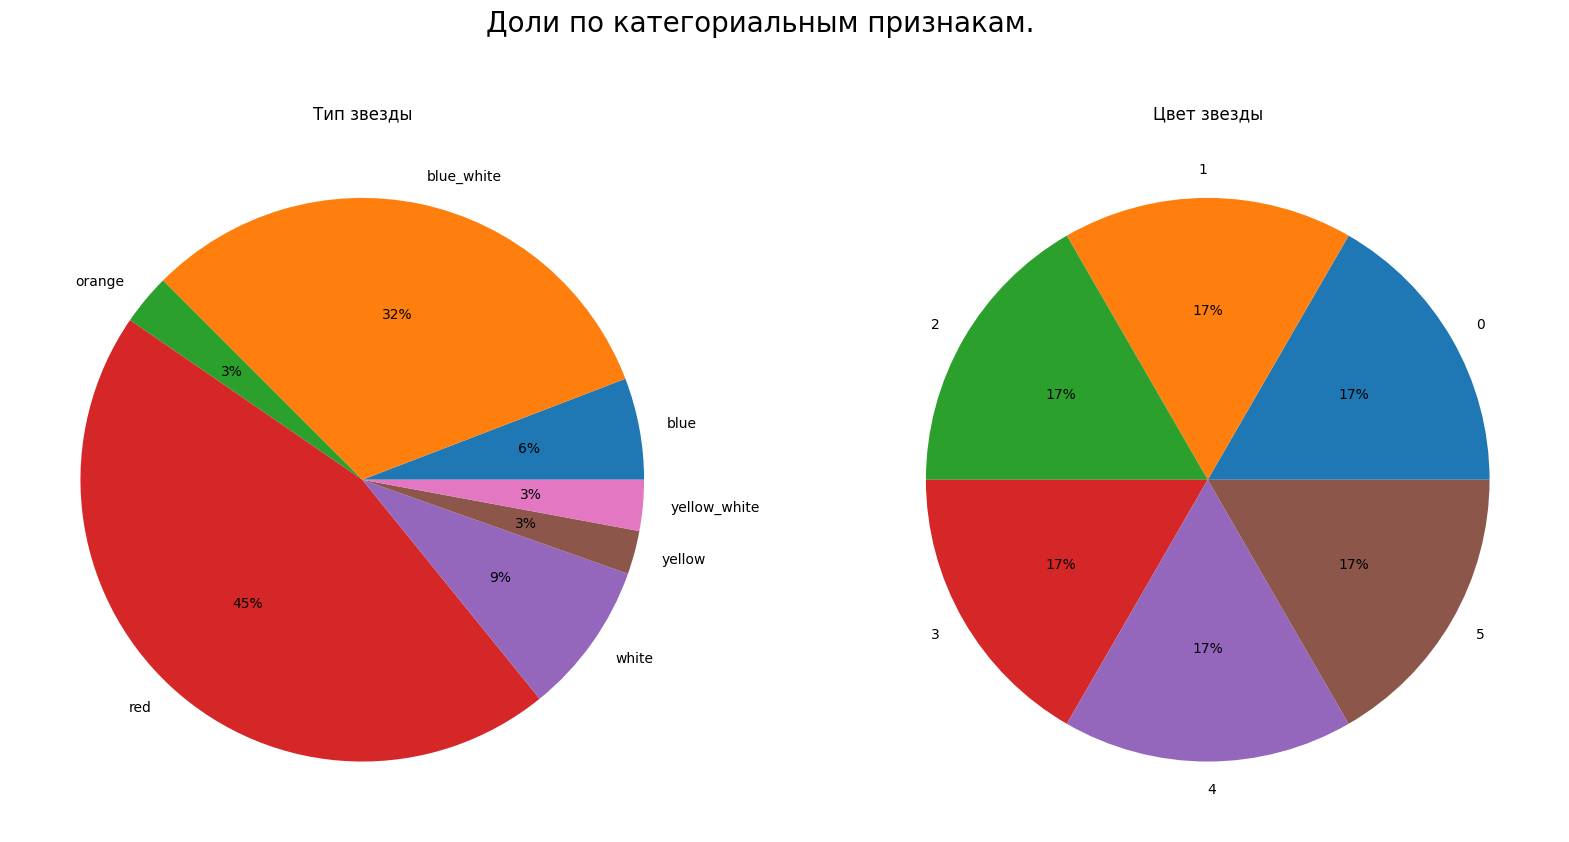

In [27]:
categorical_property_visualization(
    data_= stars_df.reset_index(),
    indexes_= cat_field_lst,
    titles_= ['Тип звезды', 'Цвет звезды'],
    values_='star_index',
    aggfunc_='count',
    title_ = 'Доли по категориальным признакам.',
    figsize_=(20, 20),
    nrows_= 1,
    ncols_= 2,
    y_title_ = 0.73)

### Спектральный классификатор

In [55]:
color_temperature_df = stars_df.groupby(
    ['star_color']
                                       ).agg(
    {'temperature': ['min', 'max', 'count']}
                                            ).reset_index()
color_temperature_df.columns = [
    'star_color',
    'temperature_min',
    'temperature_max',
    'stars_count'
                               ]

print(blue_start,'Спектральный классификатор по предоставленным данным.', color_end)
print('')
display(color_temperature_df.sort_values(by = 'temperature_min', ascending = False))

 Спектральный классификатор по предоставленным данным. 



,star_color,temperature_min,temperature_max,stars_count
0,blue,30839,40000,14
1,blue_white,10012,30000,76
4,white,7700,9892,21
6,yellow_white,6380,7282,7
5,yellow,5112,5936,6
2,orange,3826,4980,7
3,red,1939,3780,109


## Количество планет по цветам

<AxesSubplot:xlabel='star_color', ylabel='stars_count'>

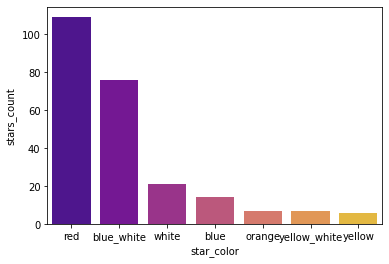

In [93]:
sns.barplot(
    x ='star_color',
    y ='stars_count',
    data = color_temperature_df.sort_values(by = 'stars_count', ascending = False),
    palette ='plasma'
           )

### Классификатор по типам звезд

In [56]:
type_temperature_df = stars_df.groupby(
    ['star_type']
                                       ).agg(
    {
    'temperature': ['min', 'max'],
    'radius': ['min', 'max'],
    'absolute_magnitude': ['min', 'max', 'count']
    }
                                            ).reset_index()
type_temperature_df.columns = [
    'star_type',
    'temperature_min',
    'temperature_max',
    'radius_min', 
    'radius_max',
    'absolute_magnitude_min', 
    'absolute_magnitude_max',
    'stars_count'
                               ]

print(blue_start,'Классификатор по типам звезд.', color_end)
print('')
display(type_temperature_df.sort_values(by = 'radius_min', ascending = False))

 Классификатор по типам звезд. 



,star_type,temperature_min,temperature_max,radius_min,radius_max,absolute_magnitude_min,absolute_magnitude_max,stars_count
5,5,3399,38940,708.9000,1948.500,-11.92,-7.580,40
4,4,3008,40000,12.0000,98.000,-7.45,-5.240,40
3,3,4077,39000,0.7950,10.600,-4.70,6.506,40
1,1,2621,3692,0.0980,0.730,10.12,14.940,40
0,0,1939,3531,0.0570,0.190,16.05,20.060,40
2,2,7100,25000,0.0084,0.015,10.18,14.870,40


В составе данных есть два категориальных поля - `star_type` и `star_color`<br>
* `star_type`
    * поле содержит числовую информацию о типе звезды.
    * Диапазон значений 0-5, целые числа, диапазон непрерывный.
    * Каждый тип звезд содержит по 40 записей (около 17%).
    * Отличия типов звезд четко прослеживается по диапазону относительных радиусов. Диапазоны относительных радиусов не пересекаются.
    * Диапазоны температур пересекаются.
    * Диапазоны амплитуд пересекаются.

* `star_color`
    * поле содержит текстовое описание наблюдаемого цвета звезды
    * среди значений поля обнаружены смысловые дубликаты, также обнаружены пробелы в начале и конце некоторых значений. После удаления лишних пробелов и дубликатов анализ значений выглядит следующим образом:

|Цвет|Количество записей|
|--------|------------------:|
|blue|56|
|blue_white|41|
|orange|2|
|orange_red|1|
|pale_yellow_orange|1|
|red|112|
|white|10|
|white_yellow|1|
|whitish|2|
|yellow_white|8|
|yellowish|3|
|yellowish_white|3|
<br>


В предоставленных данных есть информация о цвете, представленном только одной ззвездой. Такие записи попадут либо в тренировочную выборку, либо в тестовую. Такая ситуация повлияет отрицательно на работу модели. До получения результатов обучения не буду обединять, или удалять подобные записи.
<br>


[**Спектральная классификация звезд. Большая российская энциклопедия.**](https://bigenc.ru/c/spektral-nye-klassy-zviozd-c781fb "Спектральная классификация звезд") (общепринятый классификатор):

|Наблюдаемый цвет|Диапазон температуры|
|----------------|:--------------------|
|blue|30000 – 60000|
|white_blue|10000 – 30000|
|white|7500 – 10000|
|white|6000 – 7500|
|yellow-orange|3500 – 5000|
|red-orange|2000–3500|
<br>


Анализ диапазона температур в предоставленных данных о наблюдаемых цветах звезд позволяет получить **спектральный классификатор**:

|Наблюдаемый цвет|Диапазон температуры|
|----------------|:--------------------|
|blue_white|8570 - 30000|
|whitish|8052 - 9700|
|yellowish_white|7700 - 12990|
|pale_yellow_orange|7230 - 7230|
|white|7220 - 14732|
|white_yellow|7100 - 7100|
|blue|5752 - 40000|
|yellow_white|5300 - 8250|
|orange_red|5112 - 5112|
|yellowish|4077 - 4980|
|orange|3749 - 4287|
|red|1939 - 6850|

* **В предоставленных данных диапазоны температур разных наблюдаемых цветов пересекаются**
* **В предоставленных данных диапазоны температур разных типов звезд пересекаются***
* **Сравнение двух спектральных классификаторов показывает отличие перечня наблюдаемых цветов и диапазонов температур. Цвета планет в предоставленных данных приведены к общепринятому классификатору**

## Числовые поля

---------------------------------------------------------------------------------------------------------
 Поле : temperature - Температура 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64


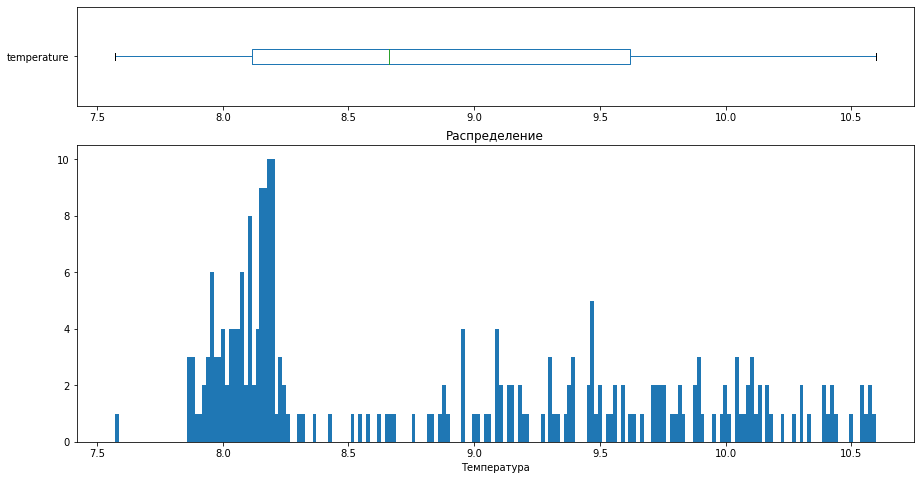

kde_plot_log_flag_ =  False


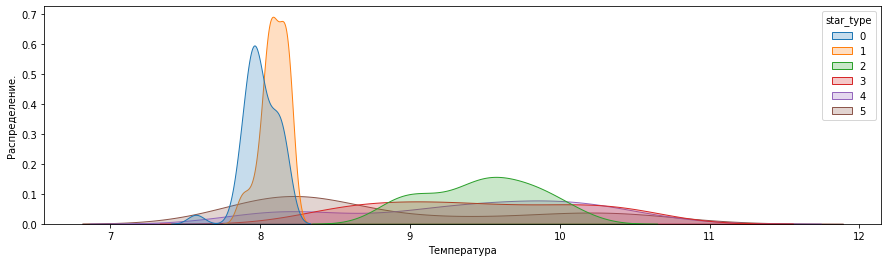

kde_plot_log_flag_ =  False


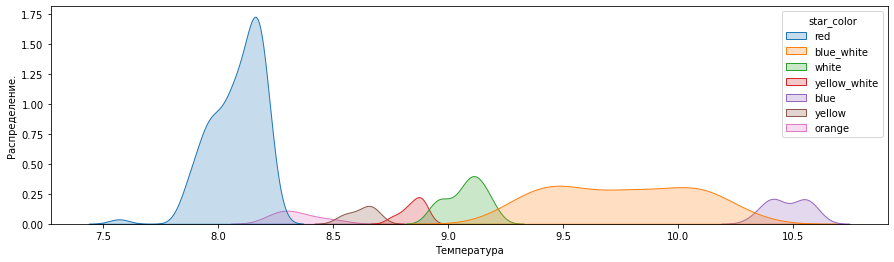

---------------------------------------------------------------------------------------------------------
 Поле : luminosity - Относительная светимость 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64


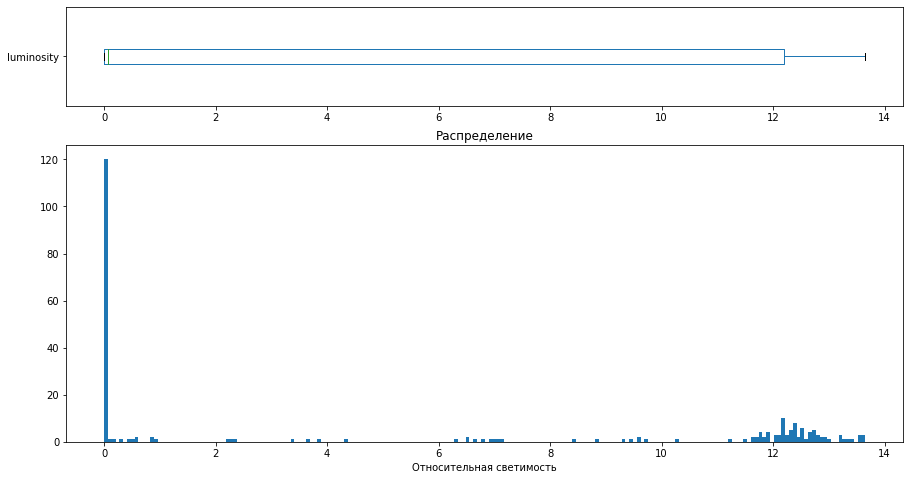

kde_plot_log_flag_ =  False


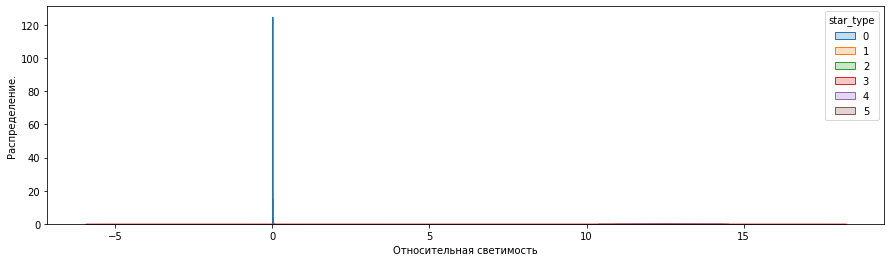

kde_plot_log_flag_ =  False


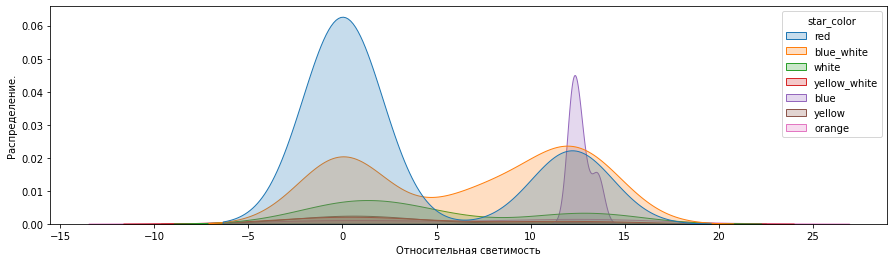

---------------------------------------------------------------------------------------------------------
 Поле : radius - Относительный радиус 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64


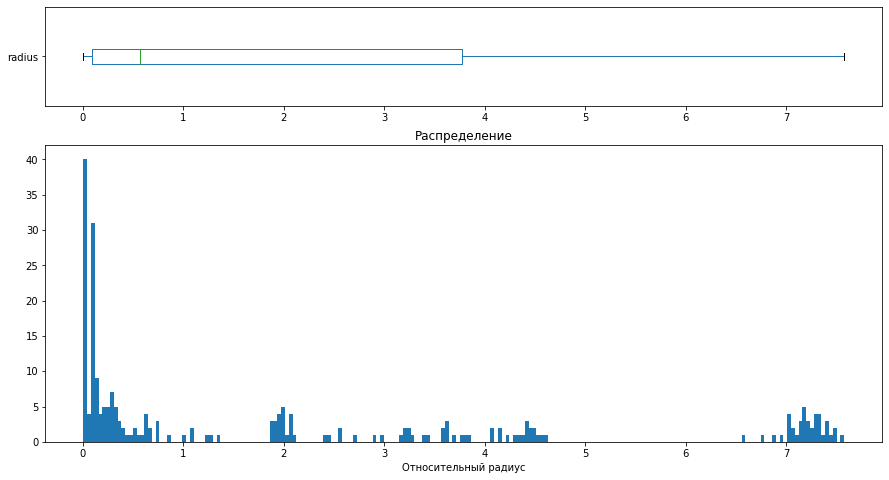

kde_plot_log_flag_ =  False


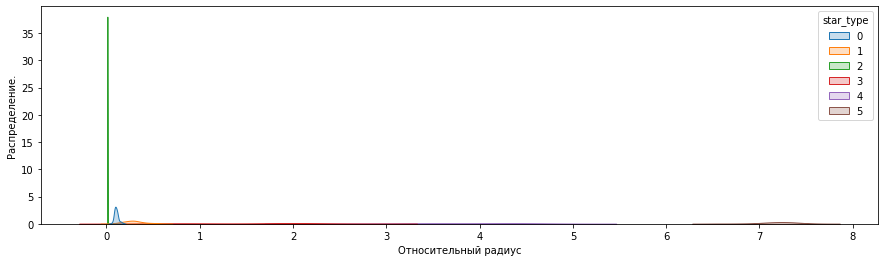

kde_plot_log_flag_ =  False


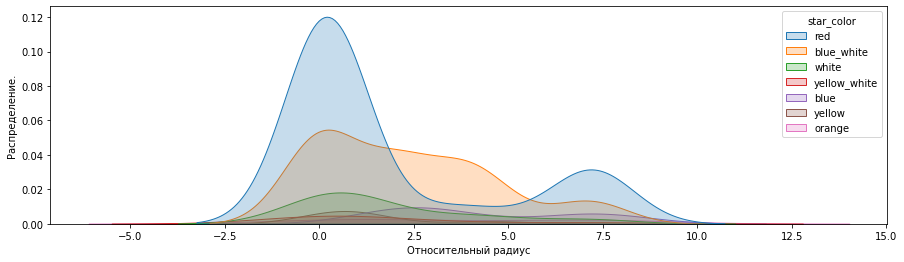

---------------------------------------------------------------------------------------------------------
 Поле : absolute_magnitude - Абсолютная звёздная величина 
     Количество пропусков -   0
     Доля пропусков -   0.0 %

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: absolute_magnitude, dtype: float64


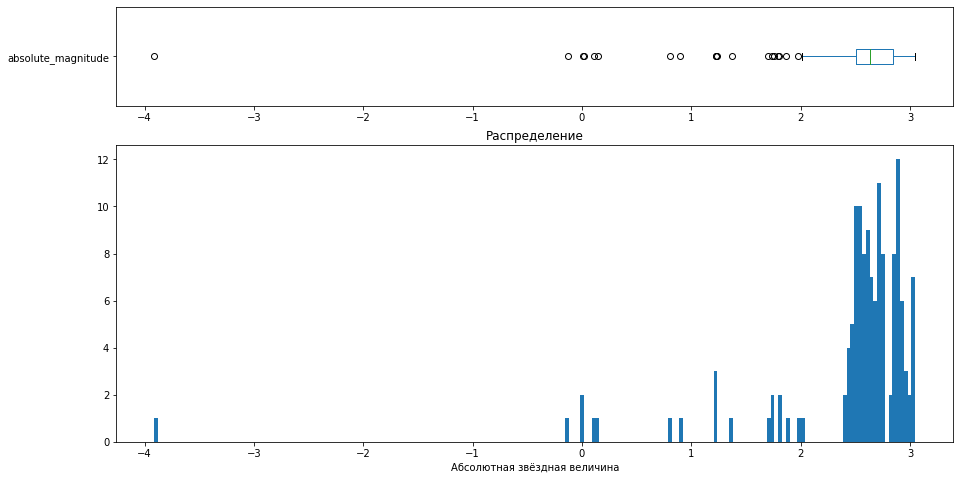

kde_plot_log_flag_ =  False


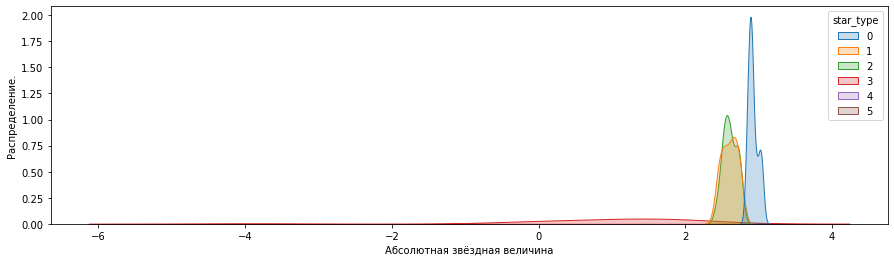

kde_plot_log_flag_ =  False


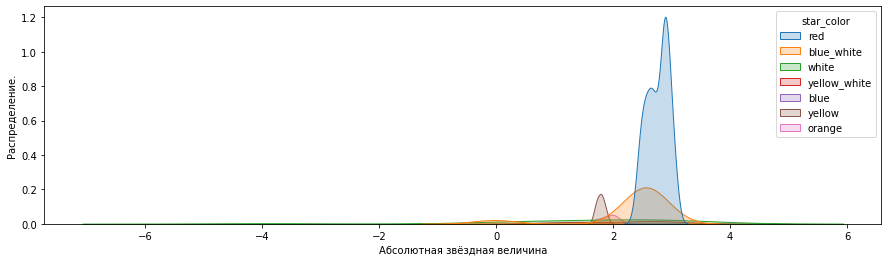

In [57]:
indexes = [
    'temperature',
    'luminosity',
    'radius',
    'absolute_magnitude'
]

titles = [
    'Температура',
    'Относительная светимость',
    'Относительный радиус',
    'Абсолютная звёздная величина'
]

kde_plot_log_flag = [
    'False',
    'False',
    'False',
    'False'
]

hue_lst = [
    'star_type',
    'star_color'
]

index = 0
for column in indexes:
    column_analiser(
        stars_df,
        column,
        x_label = titles[index],
        y_label = '',
        print_unique = False,
        bins_= 200,
        figsize_ = (15, 8),
        height_ratios_ = [1, 3],
        hue_lst_ = hue_lst, #hue_lst,
        kde_plot_log_flag_ = kde_plot_log_flag[index],
        kde_plot_figsize_ = (15, 4),
        kde_plot_title = '',
        kde_plot_x_label = titles[index],
        kde_plot_y_label = 'Распределение.'
)
    index += 1

### `Выводы`

* Распределение данных по всем числовым полям не нормальное.
* По несскольким полям обнаружены выбросы.
* Все числовые данные оставим без изменений.

## Корреляционный анализ

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'absolute_magnitude']


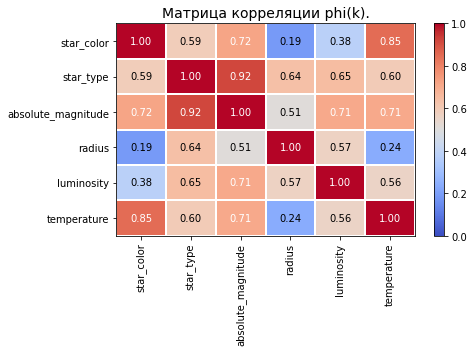

In [58]:
phik_date = stars_df.phik_matrix().round(2)

plot_correlation_matrix(phik_date.values, 
                        x_labels = phik_date.columns, 
                        y_labels = phik_date.index, 
                        vmin = 0, vmax = 1, color_map = "coolwarm", 
                        title = 'Матрица корреляции phi(k).', 
                        fontsize_factor = 1, 
                        figsize = (7, 5));
plt.tight_layout()
plt.show()

### `Выводы`

* Обнаружена высокая, но не критичная корреляция между `star_color` и `star_type`
* Значение таргета заметно коррелирует с `absolute_magnitude` и `star_color`
* По результатам корреляционного анализа данные не менялись

# Подготовка данных для формирования сети

## Разделение на Тестовую и тренировочную выборки

In [59]:
# Определение типов признаков
# Целевой
target_field = ['temperature']

# Категориальные
cat_field_lst = [
    'star_type',
    'star_color'
                ]
# Числовые
num_field_lst = indexes = [
    'luminosity',
    'radius',
    'absolute_magnitude'
]

# Разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(stars_df.drop(target_field, axis = 1),
                                                    stars_df[target_field],
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    random_state = RANDOM_STATE)

## Кодирование категориальных признаков

In [60]:
# Кодирование Категориальных признаков OneHotEncoder()

cat_encoder = OneHotEncoder(
    sparse = False,
    drop = 'first',
    handle_unknown = 'error') #sparse_output handle_unknown = 'ignore', 

X_trans = cat_encoder.fit_transform(X_train[cat_field_lst])
X_train[cat_encoder.get_feature_names()] = X_trans                     # get_feature_names_out()

X_trans = cat_encoder.fit_transform(X_test[cat_field_lst])
X_test[cat_encoder.get_feature_names()] = X_trans                      # get_feature_names_out()

## Масштабирование числовых признаков

In [61]:
# Масштабирование числовых признаков - StandardScaler()
scaler = StandardScaler()

X_train[num_field_lst] = scaler.fit_transform(X_train[num_field_lst])
X_test[num_field_lst] = scaler.fit_transform(X_test[num_field_lst])

## Удаление категориальных признаков после Кодирования

In [62]:
X_train.drop(cat_field_lst, axis = 1, inplace = True)
X_test.drop(cat_field_lst, axis = 1, inplace = True)

## Приведение X_train и X_test к единой структуре

In [63]:
# После кодирования категориальных признаков структура X_test и X_train будут отличаться
# из-за присутствия в общем датасете единичных записей некоторых значений star_color

add_cols, X_train= add_columns(from_df = X_test, to_df = X_train, fill_value = 0, sort_column_flag = True)
print('add to X_train - ', add_cols)
add_cols, X_test = add_columns(from_df = X_train, to_df = X_test, fill_value = 0, sort_column_flag = True)
print('add to X_test - ', add_cols)

add to X_train -  Index([], dtype='object')
add to X_test -  Index(['x1_yellow_white'], dtype='object')


In [64]:
display(X_train.head(3))
display(X_test.head(3))

,absolute_magnitude,luminosity,radius,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue_white,x1_orange,x1_red,x1_white,x1_yellow,x1_yellow_white
star_index,,,,,,,,,,,,,,
63,1.214583,-0.606437,-0.484390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
58,-1.456533,0.480250,1.316896,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
183,1.250577,-0.606437,-0.484377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


,absolute_magnitude,luminosity,radius,x0_1,x0_2,x0_3,x0_4,x0_5,x1_blue_white,x1_orange,x1_red,x1_white,x1_yellow,x1_yellow_white
star_index,,,,,,,,,,,,,,
216,-0.375661,-0.619146,-0.377496,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
201,0.658217,-0.619374,-0.381566,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
53,-1.274257,3.700948,3.151477,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


## Формирование тензоров по выборкам

In [65]:
X_train_torch = torch.FloatTensor(X_train.values)
X_test_torch = torch.FloatTensor(X_test.values)

y_train_torch = torch.FloatTensor(y_train.values) #
y_test_torch = torch.FloatTensor(y_test.values) #

# Построение базовой нейронной сети

## Установка параметров модели формирование объекта класса Model

In [66]:
# Количество входящих нейронов = количеству входящих признаков
N_IN_NEURONS = X_train_torch.size(1) 

# Количество нейронов первого уровня
N_HIDDEN_NEURONS_1 = 50

# Количество нейронов второго уровня
N_HIDDEN_NEURONS_2 = 20

# Количество нейронов третьего уровня
N_HIDDEN_NEURONS_3 = 5               

# Количество выходных нейронов
N_OUT_NEURONS = 1

# Функция потерь
LOSS = nn.MSELoss()

# Количество эпох
EPOCHS_COUNT = 250

# Список значений размеров батча
BATCH_SIZE = [3, 6, 12, 24]

# Количество итераций обучения
OPTIMAZE_ITTERATION_COUNT = 4

In [67]:
# формирование объекта класса Model без Dropout и BatchNorm регуляризации
net = Model(
    N_IN_NEURONS,
    N_HIDDEN_NEURONS_1,
    N_HIDDEN_NEURONS_2,
    N_HIDDEN_NEURONS_3,
    N_OUT_NEURONS,
    normalization_flag = False
           )

## Кросс-валидация `9min 31s`

In [68]:
%%time

# Формирование списка оптимизаторов для net-модели
OPTIMIZER_LST = get_optimizer_lst(net)

# Результаты процесса перебора параметров сохраняется в scores
scores = cross_val_run(
    net,
    X_train_torch,
    y_train_torch,
    optimazer_lst = OPTIMIZER_LST,
    bach_size = BATCH_SIZE,
    epochs_count = EPOCHS_COUNT,
    optimize_iteration_count = OPTIMAZE_ITTERATION_COUNT,
    loss = LOSS)

 ------------------------------------------------------------------- 
 Оптимизатор -  


RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   5579.0322
     Итерация   2  RMSE =   5520.604
     Итерация   3  RMSE =   8061.8486
     Итерация   4  RMSE =   4195.9146
 Средняя RMSE =  5839.3499 

 batch_size =   6
     Итерация   1  RMSE =   5858.1201
     Итерация   2  RMSE =   6266.4316
     Итерация   3  RMSE =   9163.2646
     Итерация   4  RMSE =   4613.1621
 Средняя RMSE =  6475.2446 

 batch_size =   12
     Итерация   1  RMSE =   6731.3306
     Итерация   2  RMSE =   6410.5088
     Итерация   3  RMSE =   9962.9395
     Итерация   4  RMSE =   5410.644
 Средняя RMSE =  7128.8557 

 batch_size =   24
     Итерация   1  RMSE =   10053.0762
     Итерация   2  RMSE =   8301.8945
     Итерация   3  RMSE =   12858.1738
     Итерация   4  RMSE =   7117.8589
 Средняя RMSE =  9582.7509 

 ------------------------------------------------------------------- 
 Оптимизатор -  


RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   4214.0142
     Итерация   2  RMSE =   3551.0701
     Итерация   3  RMSE =   3091.4321
     Итерация   4  RMSE =   4400.9102
 Средняя RMSE =  3814.3567 

 batch_size =   6
     Итерация   1  RMSE =   3984.9253
     Итерация   2  RMSE =   3445.7473
     Итерация   3  RMSE =   3170.0332
     Итерация   4  RMSE =   3779.8069
 Средняя RMSE =  3595.1282 

 batch_size =   12
     Итерация   1  RMSE =   3806.6282
     Итерация   2  RMSE =   3354.3462
     Итерация   3  RMSE =   3261.9189
     Итерация   4  RMSE =   3440.291
 Средняя RMSE =  3465.7961 

 batch_size =   24
     Итерация   1  RMSE =   3813.302
     Итерация   2  RMSE =   3683.0
     Итерация   3  RMSE =   2981.7844
     Итерация   4  RMSE =   3527.8271
 Средняя RMSE =  3501.4784 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   5332.2441
     Итерация   2  RMSE =   5076.9502
     Итерация   3  RMSE =   6788.4712
     Итерация   4  RMSE =   3649.9673
 Средняя RMSE =  5211.9082 

 batch_size =   6
     Итерация   1  RMSE =   5369.0273
     Итерация   2  RMSE =   5449.5464
     Итерация   3  RMSE =   8350.9248
     Итерация   4  RMSE =   4268.1265
 Средняя RMSE =  5859.4062 

 batch_size =   12
     Итерация   1  RMSE =   5912.8691
     Итерация   2  RMSE =   6173.3345
     Итерация   3  RMSE =   9829.6572
     Итерация   4  RMSE =   4936.8223
 Средняя RMSE =  6713.1708 

 batch_size =   24
     Итерация   1  RMSE =   7526.1353
     Итерация   2  RMSE =   6825.0879
     Итерация   3  RMSE =   16133.3877
     Итерация   4  RMSE =   12841.8457
 Средняя RMSE =  10831.6141 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   4005.3218
     Итерация   2  RMSE =   3266.5168
     Итерация   3  RMSE =   3406.4614
     Итерация   4  RMSE =   4285.2671
 Средняя RMSE =  3740.8918 

 batch_size =   6
     Итерация   1  RMSE =   4088.5562
     Итерация   2  RMSE =   3355.9277
     Итерация   3  RMSE =   3491.8672
     Итерация   4  RMSE =   4506.501
 Средняя RMSE =  3860.713 

 batch_size =   12
     Итерация   1  RMSE =   4115.3623
     Итерация   2  RMSE =   3455.6628
     Итерация   3  RMSE =   3555.0869
     Итерация   4  RMSE =   3620.4233
 Средняя RMSE =  3686.6338 

 batch_size =   24
     Итерация   1  RMSE =   4064.0671
     Итерация   2  RMSE =   3523.4729
     Итерация   3  RMSE =   3196.0312
     Итерация   4  RMSE =   3630.4319
 Средняя RMSE =  3603.5008 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   6339.042
     Итерация   2  RMSE =   6494.1099
     Итерация   3  RMSE =   10454.623
     Итерация   4  RMSE =   5724.1533
 Средняя RMSE =  7252.9821 

 batch_size =   6
     Итерация   1  RMSE =   8767.9746
     Итерация   2  RMSE =   9798.3193
     Итерация   3  RMSE =   12233.5908
     Итерация   4  RMSE =   7337.4463
 Средняя RMSE =  9534.3327 

 batch_size =   12
     Итерация   1  RMSE =   12050.2207
     Итерация   2  RMSE =   12195.1016
     Итерация   3  RMSE =   15566.5127
     Итерация   4  RMSE =   12270.0264
 Средняя RMSE =  13020.4654 

 batch_size =   24
     Итерация   1  RMSE =   12889.0498
     Итерация   2  RMSE =   12604.4863
     Итерация   3  RMSE =   16251.5996
     Итерация   4  RMSE =   12719.7109
 Средняя RMSE =  13616.2116 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   3844.1448
     Итерация   2  RMSE =   3498.3616
     Итерация   3  RMSE =   3494.2188
     Итерация   4  RMSE =   3111.1855
 Средняя RMSE =  3486.9777 

 batch_size =   6
     Итерация   1  RMSE =   4274.0654
     Итерация   2  RMSE =   3597.4917
     Итерация   3  RMSE =   4786.3608
     Итерация   4  RMSE =   3142.447
 Средняя RMSE =  3950.0912 

 batch_size =   12
     Итерация   1  RMSE =   5334.4927
     Итерация   2  RMSE =   5004.4028
     Итерация   3  RMSE =   8423.2637
     Итерация   4  RMSE =   4218.4688
 Средняя RMSE =  5745.157 

 batch_size =   24
     Итерация   1  RMSE =   5293.3569
     Итерация   2  RMSE =   6262.6636
     Итерация   3  RMSE =   8588.2549
     Итерация   4  RMSE =   4371.9102
 Средняя RMSE =  6129.0464 

CPU times: user 9min 25s, sys: 656 ms, total: 9min 26s
Wall time: 9min 31s


In [69]:
# Трансформация scores в DataFrame
scores = pd.DataFrame(scores, columns = ['optimizer_index', 'batch_size', 'RMSE'])

In [70]:
# Определение лучших параметров по результатам кросс-валидации

# best_optimizer_score_index - индекс лучшего оптимизатора из списка "зашитого" в get_optimiser_lst()
# best_batch_size
# best_RMCE

best_optimizer_score_index, best_batch_size, best_RMCE = get_best_model_validation_params(
    scores_ = scores,
    optimazer_lst = OPTIMIZER_LST,
    metrica_field = 'RMSE',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size')

 Оптимальные параматры модели: 
     Лучший оптимайцзер -   RMSprop
     Индекс оптимизатора -   1
     Размер батча -   12
 
 Значение метрики -  3465.7961 


## Обучение модели. Формирование прогноза по тестовой выборке.

In [71]:
# обучение модели по лучшим оптимайзеру и размеру батча, полученным на этапе кросс-валидации

net = fit_model(
    net,
    X_train_torch,
    y_train_torch,
    OPTIMIZER_LST[best_optimizer_score_index],
    epochs_count = EPOCHS_COUNT,
    batch_size = best_batch_size,
    loss = LOSS
            )
net.eval()

test_predict = net.forward(X_test_torch)
print(
    blue_start, 'RMSE сети на тестовой выборке = ', color_end,
    int(torch.sqrt(LOSS(y_test_torch, test_predict)))
)

 RMSE сети на тестовой выборке =   3370


## Формирование датафрейма для "Факт - прогноз" анализа

In [107]:
# Перевод тензоров в датафрейм
X_test['Прогноз'] = test_predict.detach().numpy()
X_test['Факт'] = y_test_torch.detach().numpy()

X_test.reset_index(inplace = True)

# Формирование датафрейма, содержащего начальные данные и прогноз
result_df = pd.merge(stars_df, X_test, on = 'star_index', suffixes = ('', '_trans'))

# Поле delta содержит данные об относительной разности Факта и прогноза
result_df['Относительная ошибка'] = result_df.apply(lambda x: round(abs(x.temperature - x.prediction) / x.temperature, 2) , axis = 1)

#result_df.head(3).sort_values(by = 'delta', ascending = False)

## Визуализация Факт-прогноз

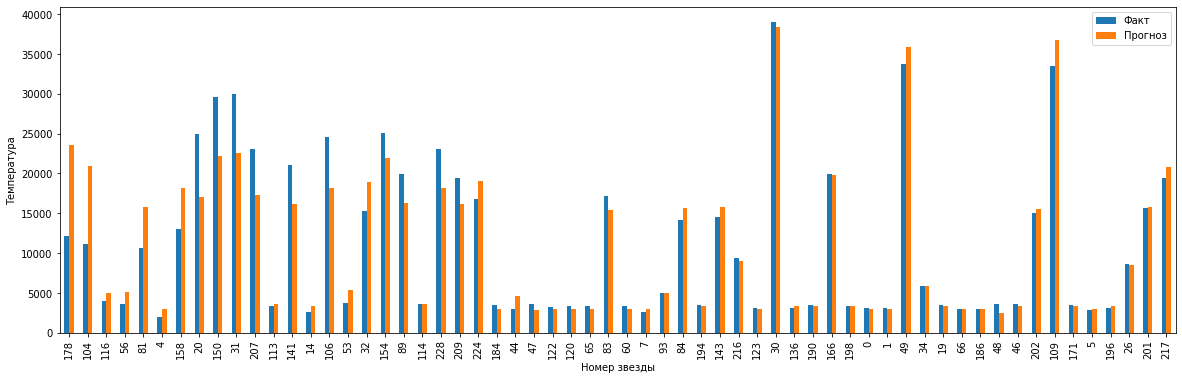

In [98]:
result_df.sort_values(by = 'Относительная ошибка', ascending = False).plot(
    x = 'star_index',
    y = ['Факт', 'Прогноз'],
    kind = "bar",
    figsize = (20, 6),
    xlabel = 'Номер звезды',
    ylabel = 'Температура'
);

## `Выводы`

* Построена сеть, содержащая два скрытых слоя, с учетом значени параметров:
    * Количество входящих нейронов = количеству входящих признаков
    * Количество нейронов первого уровня = 50
    * Количество нейронов второго уровня = 20
    * Количество выходных нейронов = 1
    * Функция потерь - `nn.MSELoss()`
    * Количество эпох = 250
    * Список значений размеров батча - 3, 6, 12, 24
    * Количество итераций обучения = 4
    * Список оптимизаторов - RMSprop, Adam, Adamax
* В процессе определения лучших параметров оценивались потери для каждого оптимизатора, со скоростями обучения `lr=1e-3` и `lr=1e-2` и по размерам батча, указанным в соответствующем параметре
* Время выполнения кросс-валидации - `6min 15s`
* **RMSE сети на тестовой выборке = 3370. Это значение удовлетворяет требование по качеству сети.**
* По Факт-прогноз визуализации (данные отсортированы по убыванию относительной ошибке) видно, что максимальные ошибки модель делает чаще для звезд с более высокой температурой.

## Улучшение нейронной сети

### Формирование объекта класса Model с включенной регуляризации

In [74]:
# формирование объекта класса Model с включенной Dropout и BatchNorm регуляризации
net_optimized = Model(
    N_IN_NEURONS,
    N_HIDDEN_NEURONS_1,
    N_HIDDEN_NEURONS_2,
    N_HIDDEN_NEURONS_3,
    N_OUT_NEURONS,
    normalization_flag = True) # Включаем Dropout и BatchNorm регуляризацю.

## Кросс-валидация. `1h 12min 12s`

In [75]:
%%time

OPTIMIZER_LST = get_optimizer_lst(net_optimized)

scores_1 = cross_val_run(
    net_optimized,
    X_train_torch,
    y_train_torch,
    optimazer_lst = OPTIMIZER_LST,
    bach_size = BATCH_SIZE,
    epochs_count = EPOCHS_COUNT,
    optimize_iteration_count = OPTIMAZE_ITTERATION_COUNT,
    loss = LOSS)

 ------------------------------------------------------------------- 
 Оптимизатор -  


RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   3771.1016
     Итерация   2  RMSE =   4381.3242
     Итерация   3  RMSE =   6984.2612
     Итерация   4  RMSE =   3764.6963
 Средняя RMSE =  4725.3458 

 batch_size =   6
     Итерация   1  RMSE =   5579.9771
     Итерация   2  RMSE =   5629.9688
     Итерация   3  RMSE =   8168.1133
     Итерация   4  RMSE =   4620.4292
 Средняя RMSE =  5999.6221 

 batch_size =   12
     Итерация   1  RMSE =   6139.4556
     Итерация   2  RMSE =   6228.7964
     Итерация   3  RMSE =   9451.5713
     Итерация   4  RMSE =   5116.9775
 Средняя RMSE =  6734.2002 

 batch_size =   24
     Итерация   1  RMSE =   6897.1987
     Итерация   2  RMSE =   6850.2012
     Итерация   3  RMSE =   9831.0654
     Итерация   4  RMSE =   5892.7959
 Средняя RMSE =  7367.8153 

 ------------------------------------------------------------------- 
 Оптимизатор -  


RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.01
    momentum: 0
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   4261.4531
     Итерация   2  RMSE =   3653.1631
     Итерация   3  RMSE =   3684.4512
     Итерация   4  RMSE =   5151.9038
 Средняя RMSE =  4187.7428 

 batch_size =   6
     Итерация   1  RMSE =   3976.4963
     Итерация   2  RMSE =   4029.7747
     Итерация   3  RMSE =   3730.5886
     Итерация   4  RMSE =   5065.4995
 Средняя RMSE =  4200.5898 

 batch_size =   12
     Итерация   1  RMSE =   3990.6003
     Итерация   2  RMSE =   3491.2244
     Итерация   3  RMSE =   4509.7407
     Итерация   4  RMSE =   3987.8008
 Средняя RMSE =  3994.8416 

 batch_size =   24
     Итерация   1  RMSE =   3857.5483
     Итерация   2  RMSE =   3522.7197
     Итерация   3  RMSE =   3092.7793
     Итерация   4  RMSE =   3980.2151
 Средняя RMSE =  3613.3156 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   4765.4512
     Итерация   2  RMSE =   3602.782
     Итерация   3  RMSE =   5072.8779
     Итерация   4  RMSE =   3136.3987
 Средняя RMSE =  4144.3775 

 batch_size =   6
     Итерация   1  RMSE =   4130.333
     Итерация   2  RMSE =   4356.4966
     Итерация   3  RMSE =   7387.3096
     Итерация   4  RMSE =   3771.5759
 Средняя RMSE =  4911.4288 

 batch_size =   12
     Итерация   1  RMSE =   5790.9521
     Итерация   2  RMSE =   5777.8262
     Итерация   3  RMSE =   8855.166
     Итерация   4  RMSE =   4967.8003
 Средняя RMSE =  6347.9362 

 batch_size =   24
     Итерация   1  RMSE =   9911.4775
     Итерация   2  RMSE =   6238.5674
     Итерация   3  RMSE =   12139.4424
     Итерация   4  RMSE =   7754.5469
 Средняя RMSE =  9011.0086 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   4325.2109
     Итерация   2  RMSE =   4041.6057
     Итерация   3  RMSE =   4131.6548
     Итерация   4  RMSE =   4488.1353
 Средняя RMSE =  4246.6517 

 batch_size =   6
     Итерация   1  RMSE =   4265.4199
     Итерация   2  RMSE =   3363.2144
     Итерация   3  RMSE =   3712.0383
     Итерация   4  RMSE =   3788.1743
 Средняя RMSE =  3782.2117 

 batch_size =   12
     Итерация   1  RMSE =   4368.8647
     Итерация   2  RMSE =   3636.4368
     Итерация   3  RMSE =   3509.5984
     Итерация   4  RMSE =   4289.2837
 Средняя RMSE =  3951.0459 

 batch_size =   24
     Итерация   1  RMSE =   3995.2075
     Итерация   2  RMSE =   3643.062
     Итерация   3  RMSE =   3372.0994
     Итерация   4  RMSE =   3536.7422
 Средняя RMSE =  3636.7778 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   6117.4546
     Итерация   2  RMSE =   6339.4019
     Итерация   3  RMSE =   9882.083
     Итерация   4  RMSE =   5591.4331
 Средняя RMSE =  6982.5932 

 batch_size =   6
     Итерация   1  RMSE =   6545.3613
     Итерация   2  RMSE =   6736.8843
     Итерация   3  RMSE =   10112.0068
     Итерация   4  RMSE =   6423.7007
 Средняя RMSE =  7454.4883 

 batch_size =   12
     Итерация   1  RMSE =   10309.8945
     Итерация   2  RMSE =   11736.748
     Итерация   3  RMSE =   15345.9795
     Итерация   4  RMSE =   10020.4287
 Средняя RMSE =  11853.2627 

 batch_size =   24
     Итерация   1  RMSE =   12793.4795
     Итерация   2  RMSE =   12660.6592
     Итерация   3  RMSE =   16501.6816
     Итерация   4  RMSE =   11898.626
 Средняя RMSE =  13463.6116 

 ------------------------------------------------------------------- 
 Оптимизатор -  


Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

 batch_size =   3
     Итерация   1  RMSE =   3669.6611
     Итерация   2  RMSE =   3500.6392
     Итерация   3  RMSE =   3257.6819
     Итерация   4  RMSE =   3196.5457
 Средняя RMSE =  3406.132 

 batch_size =   6
     Итерация   1  RMSE =   3457.4465
     Итерация   2  RMSE =   3502.9255
     Итерация   3  RMSE =   3026.3142
     Итерация   4  RMSE =   3134.9497
 Средняя RMSE =  3280.409 

 batch_size =   12
     Итерация   1  RMSE =   4141.1235
     Итерация   2  RMSE =   3969.9385
     Итерация   3  RMSE =   6246.9399
     Итерация   4  RMSE =   3655.9023
 Средняя RMSE =  4503.4761 

 batch_size =   24
     Итерация   1  RMSE =   4920.9531
     Итерация   2  RMSE =   4522.1343
     Итерация   3  RMSE =   6723.3945
     Итерация   4  RMSE =   3894.3423
 Средняя RMSE =  5015.206 

CPU times: user 1h 11min 3s, sys: 23.6 s, total: 1h 11min 26s
Wall time: 1h 12min 12s


In [108]:
# Трансформация scores_1 в DataFrame
scores_1 = pd.DataFrame(scores_1, columns = ['optimizer_index', 'batch_size', 'RMSE'])

In [109]:
# Определение лучших параметров по результатам кросс-валидации

# best_optimizer_score_index - индекс лучшего оптимизатора из списка "зашитого" в get_optimiser_lst()
# best_batch_size
# best_RMCE

best_optimizer_score_index, best_batch_size, best_RMCE = get_best_model_validation_params(
    scores_ = scores_1,
    optimazer_lst = OPTIMIZER_LST,
    metrica_field = 'RMSE',
    optimizer_index_field = 'optimizer_index',
    batch_size_field = 'batch_size')

 Оптимальные параматры модели: 
     Лучший оптимайцзер -   RMSprop
     Индекс оптимизатора -   1
     Размер батча -   12
 
 Значение метрики -  3465.7961 


## Обучение модели. Формирование прогноза по тестовой выборке.

In [110]:
# обучение модели по лучшим оптимайзеру и размеру батча, полученным на этапе кросс-валидации

net = fit_model(
    net_optimized,
    X_train_torch,
    y_train_torch,
    OPTIMIZER_LST[best_optimizer_score_index],
    epochs_count = EPOCHS_COUNT,
    batch_size = best_batch_size,
    loss = LOSS
            )
net.eval()

test_predict = net.forward(X_test_torch)
print(
    blue_start, 'RMSE сети на тестовой выборке = ', color_end,
    int(torch.sqrt(LOSS(y_test_torch, test_predict)))
)

 RMSE сети на тестовой выборке =   3195


## Формирование датафрейма для "Факт - прогноз" анализа

In [111]:
X_test['Прогноз'] = test_predict.detach().numpy()

result_df = pd.merge(
    result_df,
    X_test[['star_index', 'Прогноз']],
    on = 'star_index',
    suffixes = ('', '_trans_normalized')
                    )

# Поле delta_normalized содержит данные об относительной разности Факта и прогноза
result_df['Относительная ошибка'] = result_df.apply(
    lambda x: round(
        abs(x.temperature - x.prediction_normalized) / x.temperature, 2
                   ) , axis = 1
                                               )
#result_df.head(10).sort_values(by = 'delta_normalized', ascending = False)

## Визуализация Факт-прогноз

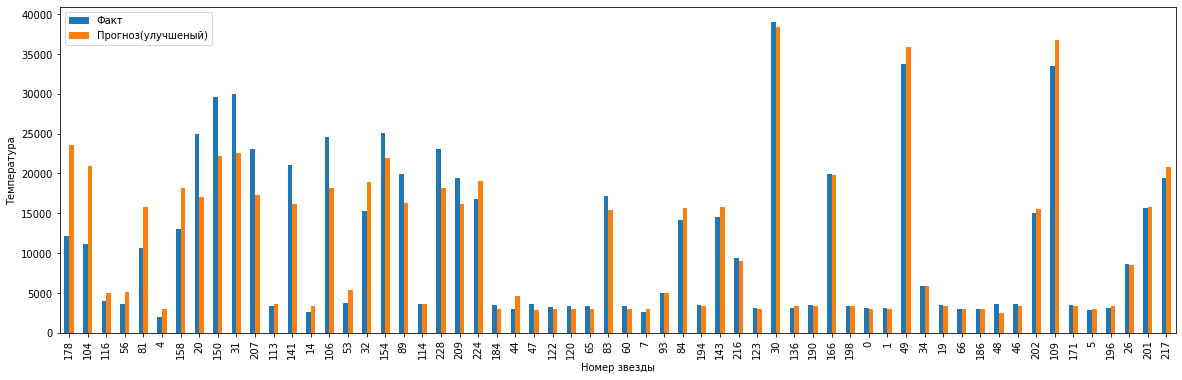

In [112]:
result_df.sort_values(by = 'Относительная ошибка', ascending = False).plot(
    x = 'star_index',
    y = ['Факт', 'Прогноз'],
    kind = "bar",
    figsize = (20, 6),
    xlabel = 'Номер звезды',
    ylabel = 'Температура'
);

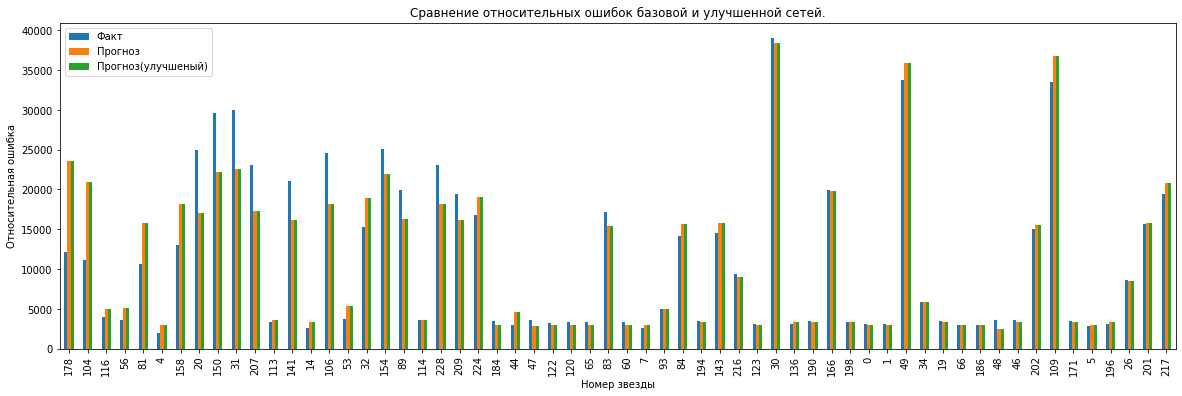

''

In [114]:
result_df.sort_values(by = 'Относительная ошибка', ascending = False).plot(
    x = 'star_index',
    y = ['Факт', 'Прогноз', 'Прогноз(улучшеный)'],
    kind = "bar",
    figsize = (20, 6),
    xlabel = 'Номер звезды',
    ylabel = 'Относительная ошибка'
)
plt.title("Сравнение относительных ошибок базовой и улучшенной сетей.")
plt.show()

;

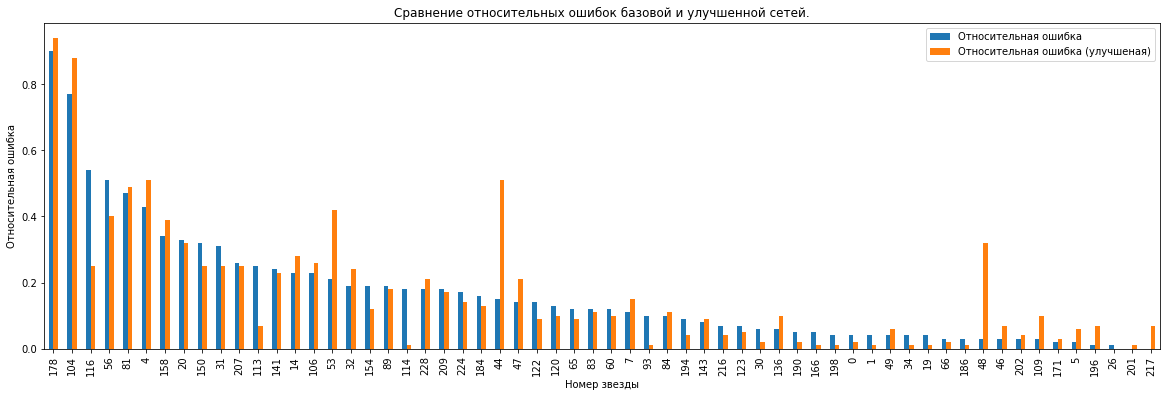

''

In [113]:
result_df.sort_values(by = 'Относительная ошибка', ascending = False).plot(
    x = 'star_index',
    y = ['Относительная ошибка', 'Относительная ошибка (улучшеная)'],
    kind = "bar",
    figsize = (20, 6),
    xlabel = 'Номер звезды',
    ylabel = 'Относительная ошибка'
)
plt.title("Сравнение относительных ошибок базовой и улучшенной сетей.")
plt.show()

;

## `Выводы`

* Для улучшения базовой модели, на втором слое добавлен регуляризатор Dropout.
* Набор и сочетание регуляризаторов и использование их на слоях проводилось путем "ручного" перебора.
* Сочетание Dropoutдали лучший RMSE на тесте = `3330`, что незначительно лучше показателя базовой модели.
* Время выполнения этапа кроссс - валидации значительно увеличился на улучшеной модели.
* **Визуализация сравнения относительных ошибок базовой и улучшеной модели показывает, что в основном относительная ошибка улучшеной модели ниже по сравнению с базовой. При этом улучшеная модель генерирует несколько аномально высоких ошибок.**

# `Общие Выводы`

* Построена и протестирована модель сети, прогнозирующая температуру звезд по предоставленным заказчиком данным.
* **Метрика RMSE базовой модели на тестовой выборке = `3370`, что соответствует требованию к качеству модели**
* Время выполнения кросс-валидации - `9min 31s`

* Для улучшения работы сети, в базовую модель добавлена Dropout регуляризация.
* Метрика RMSE улучшенной модели на тестовой выборке = `3330`, что соответствует требованию к качеству модели, и ниже значения метрики базовой модели.
* Время выполнения кросс-валидации улучшенной модели - `1h 12min 12s`
* **Время выполнения этапа кросс-валидации в разы выше,чем у базовой модели**

* **Использование Dropout регуляризации позволило незначительно улучшить базовую модель.**